In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    train_test_split, cross_validate, StratifiedKFold, 
    GridSearchCV, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score, auc,
    make_scorer
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

# mlxtend for feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Load data
arff_file = arff.loadarff("monkeypox.arff")
df = pd.DataFrame(arff_file[0])

In [3]:
# Data preprocessing: decode bytes and convert to numeric
def decode_bytes(x):
    if isinstance(x, bytes):
        return x.decode('utf-8')
    if isinstance(x, str) and x.startswith("b'"):
        return x.strip("b'").strip("'")
    return x

df = df.map(decode_bytes)

# Convert boolean columns to numeric (fixing FutureWarning)
bool_cols = ['Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 
             'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 
             'Sexually Transmitted Infection']
for col in bool_cols:
    df[col] = df[col].replace({'True': 1, 'False': 0, 'None': None}).astype('Int64')

# Convert target variable
df['MonkeyPox'] = df['MonkeyPox'].replace({'Negative': 0, 'Positive': 1}).astype(int)

/var/folders/kl/dpxvypm96c99bd3p0b_wfv0r0000gn/T/ipykernel_60355/3822951889.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'True': 1, 'False': 0, 'None': None}).astype('Int64')
/var/folders/kl/dpxvypm96c99bd3p0b_wfv0r0000gn/T/ipykernel_60355/3822951889.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'True': 1, 'False': 0, 'None': None}).astype('Int64')
/var/folders/kl/dpxvypm96c99bd3p0b_wfv0r0000gn/T/ipykernel_60355/3822951889.py:16: FutureWarning: Downcasting behavi

In [5]:
df.nunique()
# No patient ID is overlapped
# No unusual value from symptoms

Patient_ID                        24875
Systemic Illness                      4
Rectal Pain                           2
Sore Throat                           2
Penile Oedema                         2
Oral Lesions                          2
Solitary Lesion                       2
Swollen Tonsils                       2
HIV Infection                         2
Sexually Transmitted Infection        2
MonkeyPox                             2
dtype: int64

In [7]:
df['Systemic Illness'].value_counts()
# The distribution between the systemic illness status are roughly equal

Systemic Illness
Fever                    6358
Swollen Lymph Nodes      6212
None                     6186
Muscle Aches and Pain    6119
Name: count, dtype: int64

In [9]:
df['MonkeyPox'].value_counts()
# The positive case is much higher than the negative case which could affect how we analyze the final prediction. 
# The ratio of pos:neg is around 1.7.

MonkeyPox
1    15825
0     9050
Name: count, dtype: int64

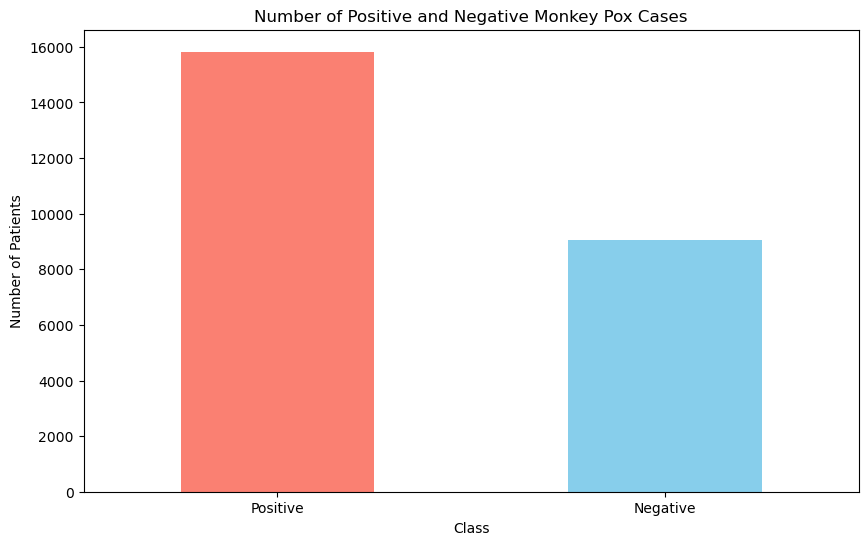

In [11]:
# Visualize class distribution
monkeypox_counts = df['MonkeyPox'].value_counts()
monkeypox_counts.plot(kind='bar', figsize=(10, 6), color=["salmon", "skyblue"])
plt.title("Number of Positive and Negative Monkey Pox Cases")
plt.xlabel("Class")
plt.ylabel("Number of Patients")
plt.xticks([0, 1], ['Positive', 'Negative'], rotation=0)
plt.show()

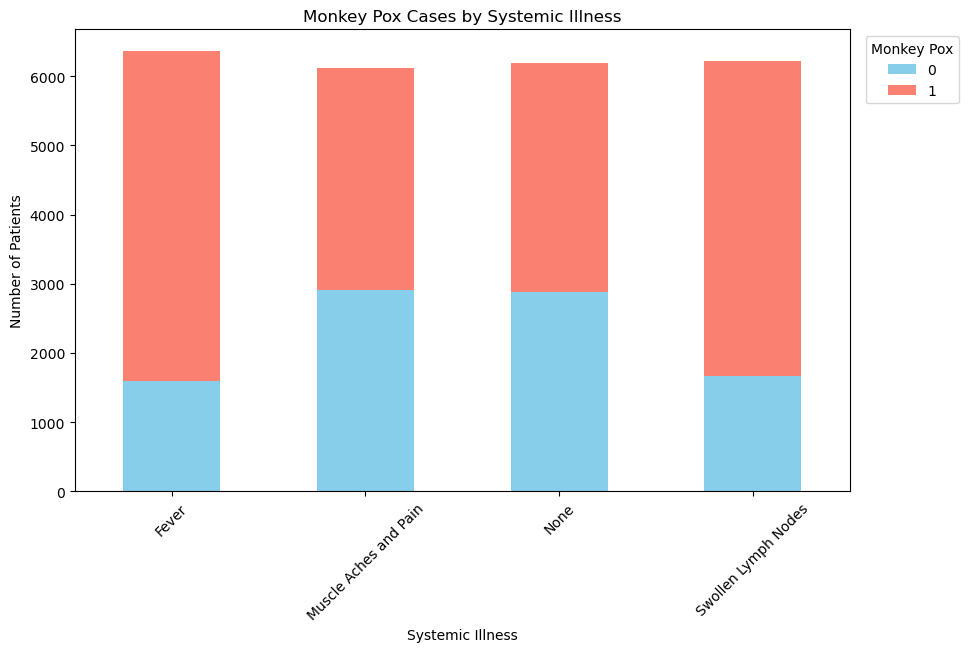

In [13]:
# Visualize distribution of Monkey Pox patients by systemic illness status
counts = df.groupby("Systemic Illness")['MonkeyPox'].value_counts().unstack()
counts.plot(kind='bar', figsize=(10, 6), stacked=True, color=["skyblue", "salmon"])
plt.title("Monkey Pox Cases by Systemic Illness")
plt.xlabel("Systemic Illness")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.legend(title="Monkey Pox", bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

In [15]:
# Create dummy variables for Systemic Illness
df_dummies = pd.get_dummies(df, columns=['Systemic Illness'], drop_first=False)
df_dummies = df_dummies.rename(columns={
    'Systemic Illness_Fever': 'Fever',
    'Systemic Illness_Muscle Aches and Pain': 'Muscle Aches and Pain',
    'Systemic Illness_None': 'None',
    'Systemic Illness_Swollen Lymph Nodes': 'Swollen Lymph Nodes'
})

# Convert dummy columns to numeric (fixing FutureWarning)
dummy_cols = ['Fever', 'Muscle Aches and Pain', 'None', 'Swollen Lymph Nodes']
for col in dummy_cols:
    df_dummies[col] = df_dummies[col].astype(int)

print(df_dummies.head())

  Patient_ID  Rectal Pain  Sore Throat  Penile Oedema  Oral Lesions  \
0      P3474            0            1              1             0   
1     P12091            1            1              0             0   
2      P6176            0            1              1             0   
3     P13990            0            0              0             1   
4     P13184            0            1              0             1   

   Solitary Lesion  Swollen Tonsils  HIV Infection  \
0                0                0              1   
1                0                1              1   
2                0                1              0   
3                0                1              1   
4                1                0              1   

   Sexually Transmitted Infection  MonkeyPox  Fever  Muscle Aches and Pain  \
0                               0          0      0                      0   
1                               1          1      0                      0   
2             

## Model Training

In [17]:
# Prepare data for modeling
X = df_dummies.drop(columns=['Patient_ID', 'MonkeyPox'])
y = df_dummies['MonkeyPox']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
knn = KNeighborsClassifier(n_neighbors=3, metric='hamming')
nb = BernoulliNB()
dt = DecisionTreeClassifier(random_state=42)

In [19]:
knn.fit(X_train, y_train)
nb.fit(X_train, y_train)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

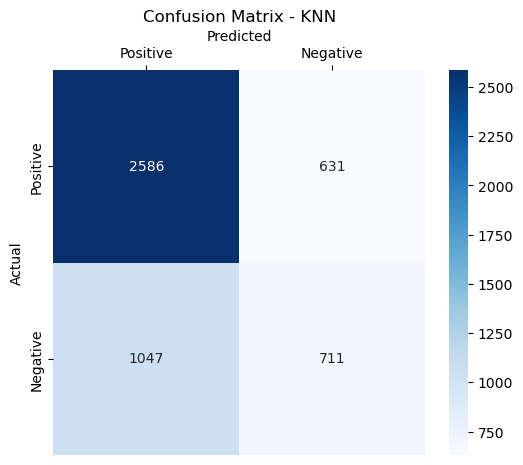


KNN Confusion Matrix:
[[ 711 1047]
 [ 631 2586]]


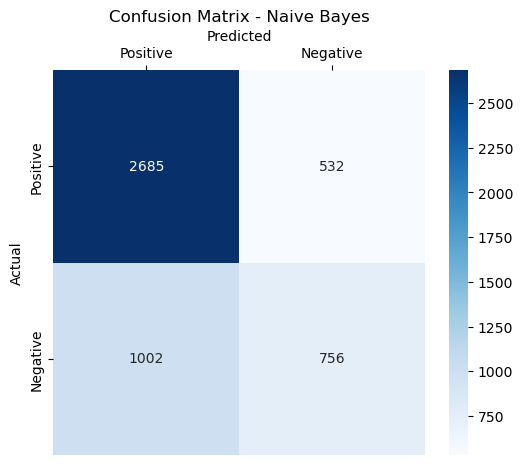


Naive Bayes Confusion Matrix:
[[ 756 1002]
 [ 532 2685]]


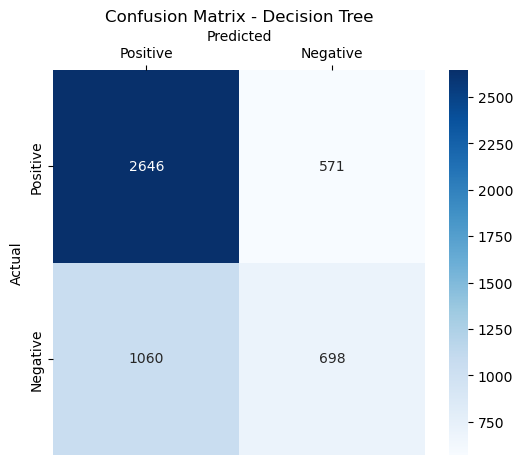


Decision Tree Confusion Matrix:
[[ 698 1060]
 [ 571 2646]]


In [21]:
# Question 1.2: Model evaluation with confusion matrices
def plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix'):
    """Helper function to plot confusion matrix"""
    cm = confusion_matrix(y_test, y_pred)
    cm_reordered = cm[::-1, ::-1]  # flips both axes
    labels = ['Positive', 'Negative']
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.gca().xaxis.set_label_position('top')
    plt.gca().xaxis.tick_top()
    plt.show()
    return cm

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Helper function to evaluate a model and return metrics"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred)
    }
    return metrics, y_pred

# Evaluate models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=9, metric='hamming'),
    'Naive Bayes': BernoulliNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

results = []
for name, model in models.items():
    metrics, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    cm = plot_confusion_matrix(y_test, y_pred, f'Confusion Matrix - {name}')
    print(f"\n{name} Confusion Matrix:\n{cm}")
    results.append(metrics)

In [23]:
results

[{'Model': 'KNN',
  'Accuracy': 0.662713567839196,
  'Precision': 0.7118084227910817,
  'Recall': 0.8038545228473734,
  'F1-score': 0.755036496350365},
 {'Model': 'Naive Bayes',
  'Accuracy': 0.6916582914572864,
  'Precision': 0.7282343368592351,
  'Recall': 0.8346285359030152,
  'F1-score': 0.7778099652375434},
 {'Model': 'Decision Tree',
  'Accuracy': 0.6721608040201005,
  'Precision': 0.7139773340528872,
  'Recall': 0.8225054398507927,
  'F1-score': 0.7644084934277048}]

In [25]:
# Find the best k for kNN
def evaluate_knn_weights(X_train, X_test, y_train, y_test, k_values, weights='uniform'):
    """Helper function to evaluate kNN with different k values"""
    print(f"\n=== kNN with {weights} weights ===")
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, weights=weights, metric='hamming')
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred) * 100
        precision = precision_score(y_test, y_pred) * 100
        recall = recall_score(y_test, y_pred) * 100
        f1 = f1_score(y_test, y_pred) * 100
        
        print(f"k = {k:2d} | Accuracy = {accuracy:.2f}% | Precision = {precision:.2f}% | "
              f"Recall = {recall:.2f}% | F1 Score = {f1:.2f}%")

k_values = range(3, 20, 2)
evaluate_knn_weights(X_train, X_test, y_train, y_test, k_values, weights='uniform')
evaluate_knn_weights(X_train, X_test, y_train, y_test, k_values, weights='distance')


=== kNN with uniform weights ===
k =  3 | Accuracy = 63.04% | Precision = 70.11% | Recall = 74.67% | F1 Score = 72.32%
k =  5 | Accuracy = 65.11% | Precision = 71.00% | Recall = 77.84% | F1 Score = 74.26%
k =  7 | Accuracy = 65.47% | Precision = 70.63% | Recall = 79.76% | F1 Score = 74.92%
k =  9 | Accuracy = 66.27% | Precision = 71.18% | Recall = 80.39% | F1 Score = 75.50%
k = 11 | Accuracy = 66.33% | Precision = 71.04% | Recall = 80.91% | F1 Score = 75.66%
k = 13 | Accuracy = 67.22% | Precision = 71.39% | Recall = 82.28% | F1 Score = 76.45%
k = 15 | Accuracy = 67.50% | Precision = 71.73% | Recall = 82.10% | F1 Score = 76.56%
k = 17 | Accuracy = 67.46% | Precision = 71.30% | Recall = 83.15% | F1 Score = 76.77%
k = 19 | Accuracy = 67.66% | Precision = 71.47% | Recall = 83.18% | F1 Score = 76.89%

=== kNN with distance weights ===
k =  3 | Accuracy = 63.04% | Precision = 70.11% | Recall = 74.67% | F1 Score = 72.32%
k =  5 | Accuracy = 65.11% | Precision = 71.00% | Recall = 77.84% | F1 

In [27]:
# Test distance-weighted kNN (note: minimal difference with binary/categorical data)
knn_dist = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='hamming')
knn_dist.fit(X_train, y_train)
y_pred = knn_dist.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with k=3 (distance-weighted): {accuracy:.4f}")
# Note: Does not significantly change since we're using binary/categorical data,
# so the distance between points is fixed.

Accuracy with k=3 (distance-weighted): 0.6304


In [29]:
# Cross-validation evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv_models = {
    'kNN': KNeighborsClassifier(n_neighbors=9, metric='hamming'),
    'Naive Bayes': BernoulliNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Perform cross-validation for each model
for name, model in cv_models.items():
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    
    print(f"\n{name} Average Metrics (5-fold CV):")
    print(f"Accuracy : {scores['test_accuracy'].mean()*100:.2f}%")
    print(f"Precision: {scores['test_precision'].mean()*100:.2f}%")
    print(f"Recall   : {scores['test_recall'].mean()*100:.2f}%")
    print(f"F1 Score : {scores['test_f1'].mean()*100:.2f}%")



kNN Average Metrics (5-fold CV):
Accuracy : 65.98%
Precision: 70.03%
Recall   : 81.34%
F1 Score : 75.26%

Naive Bayes Average Metrics (5-fold CV):
Accuracy : 68.76%
Precision: 71.49%
Recall   : 84.66%
F1 Score : 77.52%

Decision Tree Average Metrics (5-fold CV):
Accuracy : 67.26%
Precision: 70.16%
Recall   : 84.46%
F1 Score : 76.65%


In [31]:
# Find best k using cross-validation
print("Finding best k using cross-validation:")
for k in range(3, 10, 2):
    knn = KNeighborsClassifier(n_neighbors=k, metric='hamming')
    scores = cross_val_score(knn, X, y, cv=5, scoring="accuracy")
    print(f"Average accuracy with k={k}: {scores.mean():.4f}")


Finding best k using cross-validation:
Average accuracy with k=3: 0.6247
Average accuracy with k=5: 0.6430
Average accuracy with k=7: 0.6548
Average accuracy with k=9: 0.6612


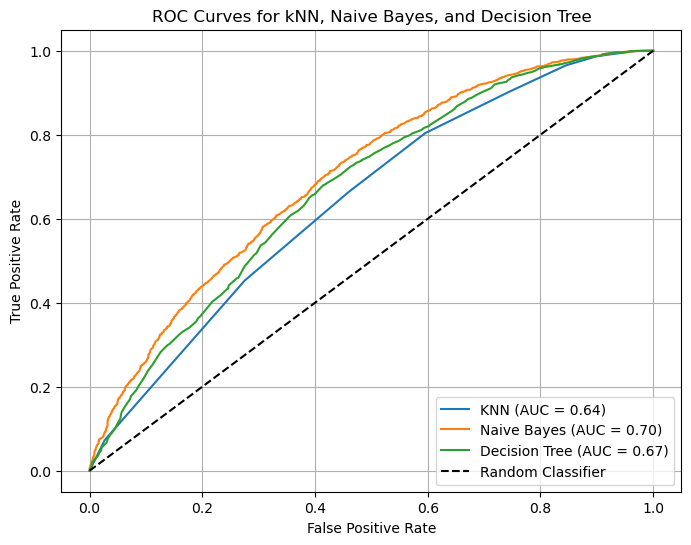

In [33]:
# Question 1.3: ROC Curves
roc_models = {
    'KNN': KNeighborsClassifier(n_neighbors=9, metric='hamming'),
    'Naive Bayes': BernoulliNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train models and plot ROC curves
plt.figure(figsize=(8, 6))
for name, model in roc_models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('ROC Curves for kNN, Naive Bayes, and Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Analysis: Naive Bayes performs best (highest AUC), followed by Decision Tree. 
# kNN performs worst, which is expected since the dataset contains only binary/categorical 
# values, making distance metrics less meaningful. However, overall performance is still 
# limited for practical use in medical diagnosis.

In [35]:
# Question 1.4: Feature Selection using Information Gain (Filter Method)
info_gain = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

ig_df = pd.DataFrame({
    'Feature': X.columns,
    'Information_Gain': info_gain
}).sort_values(by='Information_Gain', ascending=False)

def evaluate_with_top_k_features(model, X, y, ig_df):
    """Evaluate model performance using top k features based on information gain"""
    f1_scores = []
    for k in range(1, len(ig_df) + 1):
        feature_list = ig_df['Feature'][:k].tolist()
        X_sub = X[feature_list]
        X_train, X_test, y_train, y_test = train_test_split(
            X_sub, y, test_size=0.2, random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))
    return f1_scores

# Evaluate models with different numbers of top features
ig_models = {
    'KNN': KNeighborsClassifier(n_neighbors=9, metric='hamming'),
    'Naive Bayes': BernoulliNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

ig_results = {}
for name, model in ig_models.items():
    ig_results[name] = evaluate_with_top_k_features(model, X, y, ig_df)

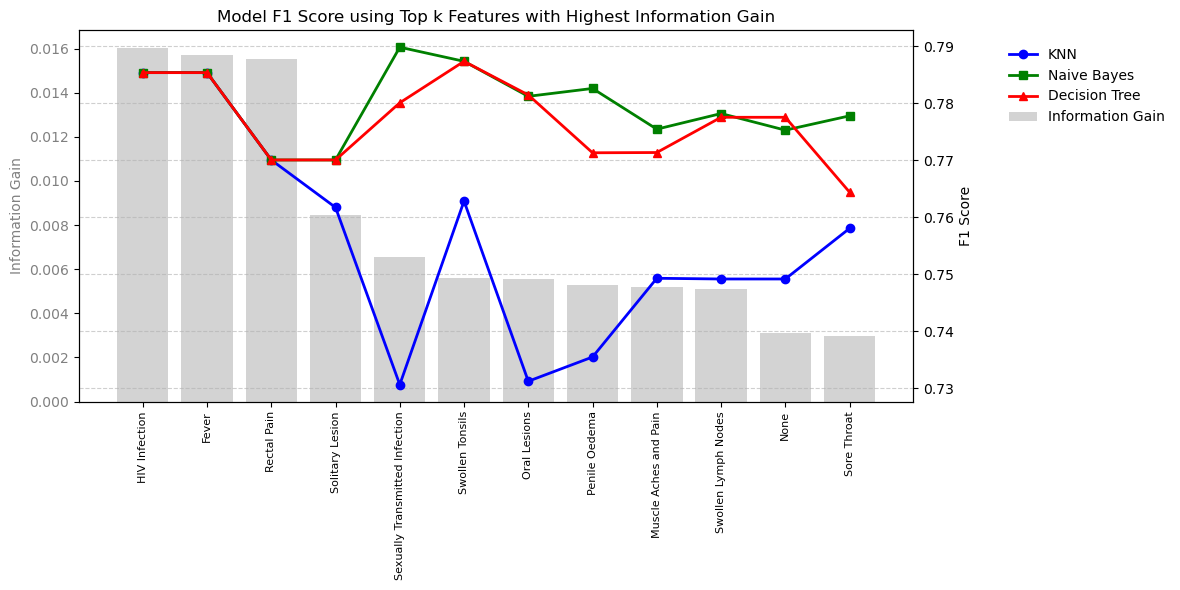

In [37]:
# Plot Information Gain vs F1 Score for different numbers of features
x = np.arange(1, len(ig_df) + 1)
fig, ax2 = plt.subplots(figsize=(12, 6))

# Bar chart for Information Gain
ax2.bar(x, ig_df['Information_Gain'], color='lightgrey', alpha=1, label='Information Gain')
ax2.set_ylabel('Information Gain', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Line plot for model F1 scores (secondary y-axis)
ax1 = ax2.twinx()
colors = {'KNN': 'blue', 'Naive Bayes': 'green', 'Decision Tree': 'red'}
markers = {'KNN': 'o', 'Naive Bayes': 's', 'Decision Tree': '^'}
for name in ig_results.keys():
    ax1.plot(x, ig_results[name], label=name, color=colors[name], 
             marker=markers[name], linewidth=2)

ax1.set_xlabel('Features (ranked by Information Gain)')
ax1.set_ylabel('F1 Score', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='both', linestyle='--', alpha=0.6)

# Feature labels on x-axis
ax2.set_xticks(x)
ax2.set_xticklabels(ig_df['Feature'], rotation=90, fontsize=8)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + bar_labels, loc='center left',
          bbox_to_anchor=(1.1, 0.85), frameon=False)

plt.title('Model F1 Score using Top k Features with Highest Information Gain')
plt.subplots_adjust(bottom=0.35)
plt.tight_layout()
plt.show()

### Note:
Since I forgot to set the random seed for the information gain calculation, the result might slightly be different from the report. However, the general idea remains the same. The IG-based feature subset is not as optimal as the FBS-based feature subset. 

In [39]:
# Feature Selection using Wrapper Method (Sequential Feature Selection)
def backward_feature_selection(model, X_train, X_test, y_train, y_test):
    """Perform backward floating feature selection using F1 score"""
    f1_scorer = make_scorer(f1_score)
    sfs = SFS(
        model,
        k_features='best',
        forward=False,  # Backward selection
        floating=True,  # Floating selection
        scoring=f1_scorer,
        cv=None
    )
    
    sfs = sfs.fit(X_train, y_train)
    selected_features = list(sfs.k_feature_names_)
    
    # Evaluate on test data
    X_train_sfs = sfs.transform(X_train)
    X_test_sfs = sfs.transform(X_test)
    model.fit(X_train_sfs, y_train)
    y_pred = model.predict(X_test_sfs)
    
    return {
        'features': selected_features,
        'recall': recall_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'cv_f1': sfs.k_score_
    }

# Perform feature selection for each model
sfs_models = {
    'KNN': KNeighborsClassifier(n_neighbors=9, metric='hamming'),
    'Naive Bayes': BernoulliNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

X_train_sfs, X_test_sfs, y_train_sfs, y_test_sfs = train_test_split(
    X, y, test_size=0.2, random_state=42
)

best_features_dict = {}
for name, model in sfs_models.items():
    best_features_dict[name] = backward_feature_selection(
        model, X_train_sfs, X_test_sfs, y_train_sfs, y_test_sfs
    )
    
    print(f'\nModel: {name}')
    print(f'Selected Features: {len(best_features_dict[name]["features"])}')
    print(f'Recall: {best_features_dict[name]["recall"]:.4f}')
    print(f'Accuracy: {best_features_dict[name]["accuracy"]:.4f}')
    print(f'Precision: {best_features_dict[name]["precision"]:.4f}')
    print(f'F1 Score: {best_features_dict[name]["f1"]:.4f}')
    print(f'F1 Score (CV): {best_features_dict[name]["cv_f1"]:.4f}')
    print('-' * 50)


Model: KNN
Selected Features: 4
Recall: 0.9633
Accuracy: 0.6629
Precision: 0.6653
F1 Score: 0.7870
F1 Score (CV): 0.7813
--------------------------------------------------

Model: Naive Bayes
Selected Features: 10
Recall: 0.9024
Accuracy: 0.7015
Precision: 0.7126
F1 Score: 0.7963
F1 Score (CV): 0.7871
--------------------------------------------------

Model: Decision Tree
Selected Features: 11
Recall: 0.8809
Accuracy: 0.6911
Precision: 0.7106
F1 Score: 0.7867
F1 Score (CV): 0.7890
--------------------------------------------------


In [ ]:
# Display selected features for each model
for name, result in best_features_dict.items():
    print(f"{name} selected features: {result['features']}")

['Rectal Pain', 'Oral Lesions', 'HIV Infection', 'Muscle Aches and Pain']
['Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'Sexually Transmitted Infection', 'Muscle Aches and Pain', 'None']
['Rectal Pain', 'Sore Throat', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'Sexually Transmitted Infection', 'Fever', 'Muscle Aches and Pain', 'None', 'Swollen Lymph Nodes']


In [ ]:
# Evaluate models with selected features from wrapper method
def evaluate_with_features(model, feature_list, X, y):
    """Evaluate model with a specific feature subset"""
    X_sub = X[feature_list]
    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y, test_size=0.2, random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred)
    }

# Extract selected features from wrapper method
feature_selection_models = {
    'KNN': KNeighborsClassifier(n_neighbors=9, metric='hamming'),
    'Naive Bayes': BernoulliNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

fbs_test_results = {}
for name, model in feature_selection_models.items():
    selected_features = best_features_dict[name]['features']
    fbs_test_results[name] = evaluate_with_features(model, selected_features, X, y)

In [770]:
fbs_test_result

{'KNN': (0.9633198632266087,
  0.6653069987118935,
  0.787047619047619,
  0.6629145728643216),
 'Naive Bayes': (0.9023935343487721,
  0.7125675012272951,
  0.7963242353586614,
  0.7015075376884422),
 'Decision Tree': (0.8809449797948399,
  0.7106318956870612,
  0.786675919500347,
  0.6910552763819096)}

In [ ]:
# Evaluate models with top 5 features from Information Gain
ig_top_features = ig_df['Feature'][:5].tolist()
print(f"Top 5 features by Information Gain: {ig_top_features}")

ig_test_results = {}
for name, model in feature_selection_models.items():
    ig_test_results[name] = evaluate_with_features(model, ig_top_features, X, y)

ig_test_results

{'KNN': (0.7401305564190239,
  0.6691961776278809,
  0.7028782287822878,
  0.5953768844221106),
 'Naive Bayes': (0.8809449797948399,
  0.7006180469715698,
  0.7805012393280089,
  0.6795979899497487),
 'Decision Tree': (0.8809449797948399,
  0.7006180469715698,
  0.7805012393280089,
  0.6795979899497487)}

In [ ]:
# Display results for wrapper method feature selection
print("Results with Wrapper Method (Backward Selection) Features:")
for name, result in fbs_test_results.items():
    print(f"\n{name}:")
    print(f"  Recall:    {result['recall']*100:.2f}%")
    print(f"  Precision: {result['precision']*100:.2f}%")
    print(f"  F1 Score:  {result['f1']*100:.2f}%")
    print(f"  Accuracy:  {result['accuracy']*100:.2f}%")

96.33%
66.53%
78.7%
66.29%
90.24%
71.26%
79.63%
70.15%
88.09%
71.06%
78.67%
69.11%


In [ ]:
# Hyperparameter Tuning: Decision Tree
dt_features = best_features_dict['Decision Tree']['features']
X_dt = df_dummies[dt_features]
y_dt = df_dummies['MonkeyPox']
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(
    X_dt, y_dt, test_size=0.2, random_state=42
)

dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    scoring='f1',
    cv=5
)
dt_grid.fit(X_train_dt, y_train_dt)
print(f"Best Decision Tree parameters: {dt_grid.best_params_}")

Best DT params: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Evaluate tuned Decision Tree
dt_best = dt_grid.best_estimator_
dt_best.fit(X_train_dt, y_train_dt)
y_pred_dt = dt_best.predict(X_test_dt)

dt_metrics = {
    'recall': recall_score(y_test_dt, y_pred_dt),
    'precision': precision_score(y_test_dt, y_pred_dt),
    'f1': f1_score(y_test_dt, y_pred_dt),
    'accuracy': accuracy_score(y_test_dt, y_pred_dt)
}

print("Tuned Decision Tree Results:")
for metric, value in dt_metrics.items():
    print(f"  {metric.capitalize()}: {value*100:.2f}%")

88.87%
71.12%
79.01%
69.47%


In [ ]:
# Hyperparameter Tuning: Naive Bayes
nb_features = best_features_dict['Naive Bayes']['features']
X_nb = df_dummies[nb_features]
y_nb = df_dummies['MonkeyPox']
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X_nb, y_nb, test_size=0.2, random_state=42
)

nb_params = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}
nb_grid = GridSearchCV(BernoulliNB(), nb_params, scoring='f1', cv=5)
nb_grid.fit(X_train_nb, y_train_nb)
print(f"Best Naive Bayes parameters: {nb_grid.best_params_}")

Best NB params: {'alpha': 0.5, 'fit_prior': True}


In [ ]:
# Evaluate tuned Naive Bayes
nb_best = nb_grid.best_estimator_
nb_best.fit(X_train_nb, y_train_nb)
y_pred_nb = nb_best.predict(X_test_nb)

nb_metrics = {
    'recall': recall_score(y_test_nb, y_pred_nb),
    'precision': precision_score(y_test_nb, y_pred_nb),
    'f1': f1_score(y_test_nb, y_pred_nb),
    'accuracy': accuracy_score(y_test_nb, y_pred_nb)
}

print("Tuned Naive Bayes Results:")
for metric, value in nb_metrics.items():
    print(f"  {metric.capitalize()}: {value*100:.2f}%")

90.24%
71.26%
79.63%
70.15%


Explained variance ratio: [0.09374347 0.09254556]
Total variance explained: 0.18628903830267574


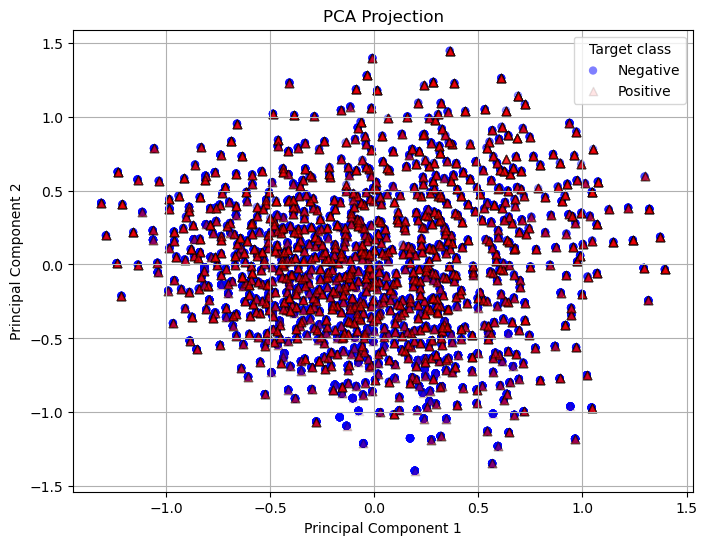

In [ ]:
# PCA Analysis
X_pca_full = df_dummies.drop(columns=['Patient_ID', 'MonkeyPox'])
y_pca_full = df_dummies['MonkeyPox']

# 2D PCA visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_pca_full)

print(f"Explained variance ratio: {pca_2d.explained_variance_ratio_}")
print(f"Total variance explained: {pca_2d.explained_variance_ratio_.sum():.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[y_pca_full == 0, 0], X_pca_2d[y_pca_full == 0, 1],
            label='Negative', color='blue', marker='o', alpha=0.5, edgecolor='none')
plt.scatter(X_pca_2d[y_pca_full == 1, 0], X_pca_2d[y_pca_full == 1, 1],
            label='Positive', color='red', marker='^', alpha=0.5, edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (2D)')
plt.legend(title='Target class')
plt.grid(True)
plt.show()

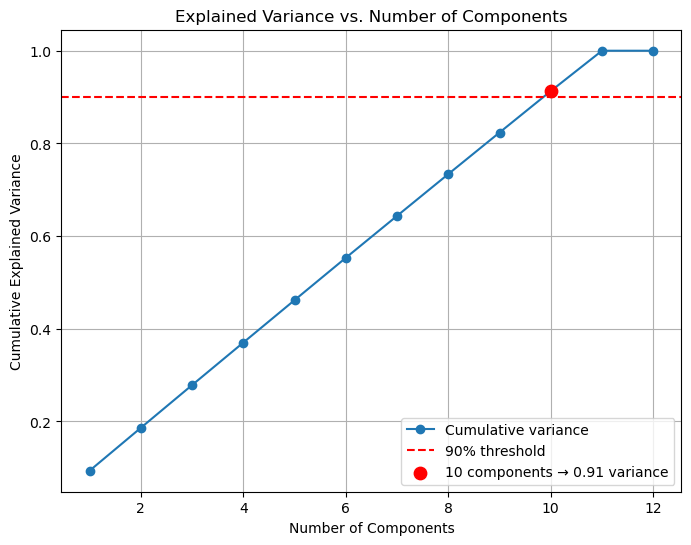

In [1040]:
# Fit PCA
pca = PCA().fit(X)

# Compute cumulative variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

# Find the first component where variance > 0.9
k_90 = np.argmax(cum_var >= 0.9) + 1  # +1 because index starts at 0
var_90 = cum_var[k_90 - 1]

# Plot cumulative explained variance
plt.figure(figsize=(8,6))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o', label='Cumulative variance')

# Highlight the 90% threshold
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.scatter(k_90, var_90, color='red', s=80, zorder=5, label=f'{k_90} components → {var_90:.2f} variance')

# Labels and legend
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Apply PCA with 10 components for model evaluation
pca_10 = PCA(n_components=10)
X_pca = pca_10.fit_transform(X_pca_full)

In [ ]:
# Evaluate models with PCA-transformed features (10 components)
pca_models = {
    'KNN': KNeighborsClassifier(n_neighbors=9, metric='hamming'),
    'Naive Bayes': BernoulliNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_pca_full, test_size=0.2, random_state=42
)

print("Results with PCA-transformed features (10 components):")
for name, model in pca_models.items():
    model.fit(X_train_pca, y_train_pca)
    y_pred = model.predict(X_test_pca)
    
    print(f"\n{name}:")
    print(f"  Recall:    {recall_score(y_test_pca, y_pred)*100:.2f}%")
    print(f"  Precision: {precision_score(y_test_pca, y_pred)*100:.2f}%")
    print(f"  F1 Score:  {f1_score(y_test_pca, y_pred)*100:.2f}%")
    print(f"  Accuracy:  {accuracy_score(y_test_pca, y_pred)*100:.2f}%")

KNN Result:
80.6%
70.89%
75.43%
66.05%
Naive Bayes Result:
89.31%
69.26%
78.02%
67.46%
Decision Tree Result:
82.25%
71.4%
76.44%
67.22%


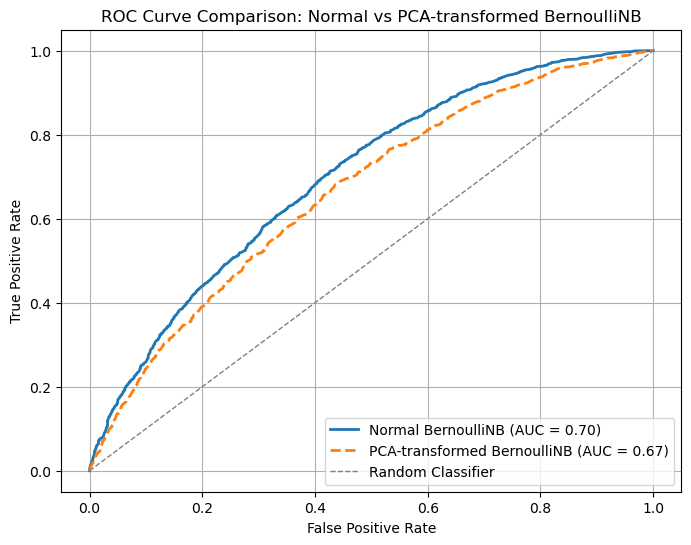

In [41]:
# Compare ROC curves: Normal vs PCA-transformed Naive Bayes
X_roc = df_dummies.drop(columns=['Patient_ID', 'MonkeyPox'])
y_roc = df_dummies['MonkeyPox']
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(
    X_roc, y_roc, test_size=0.2, random_state=42
)

# Train normal Bernoulli NB
nb_normal = BernoulliNB()
nb_normal.fit(X_train_roc, y_train_roc)
y_prob_normal = nb_normal.predict_proba(X_test_roc)[:, 1]
fpr_normal, tpr_normal, _ = roc_curve(y_test_roc, y_prob_normal)
auc_normal = roc_auc_score(y_test_roc, y_prob_normal)

# Train PCA-transformed Bernoulli NB
pca_roc = PCA(n_components=10)
X_pca_train_roc = pca_roc.fit_transform(X_train_roc)
X_pca_test_roc = pca_roc.transform(X_test_roc)
nb_pca = BernoulliNB()
nb_pca.fit(X_pca_train_roc, y_train_roc)
y_prob_pca = nb_pca.predict_proba(X_pca_test_roc)[:, 1]
fpr_pca, tpr_pca, _ = roc_curve(y_test_roc, y_prob_pca)
auc_pca = roc_auc_score(y_test_roc, y_prob_pca)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_normal, tpr_normal, label=f'Normal BernoulliNB (AUC = {auc_normal:.2f})', lw=2)
plt.plot(fpr_pca, tpr_pca, label=f'PCA-transformed BernoulliNB (AUC = {auc_pca:.2f})', 
         lw=2, linestyle='--')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Normal vs PCA-transformed BernoulliNB')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()